In [424]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

case_to_evaluate="9_3_2"
percentage_per_case = "0_2"

In [425]:
# Load data
distance_based_r2_scores = pd.read_csv(f"data/{case_to_evaluate}/distance_based/combined_r2_scores.csv")
distance_based_r2_scores["Origin"] = "Distance Based"
neighbor_based_r2_scores = pd.read_csv(f"data/{case_to_evaluate}/neighbor_based/combined_r2_scores.csv")

vae_r2_scores = pd.read_csv(f"data/{case_to_evaluate}/vae_normal/{percentage_per_case}/combined_r2_scores.csv")
vae_r2_scores["Origin"] = "VAE"

spatial_neighboor_hood_scores = neighbor_based_r2_scores[~neighbor_based_r2_scores["Origin"].str.contains("no_spatial")].copy()
no_spatial_neighboor_hood_scores = neighbor_based_r2_scores[neighbor_based_r2_scores["Origin"].str.contains("no_spatial")].copy()

# Performance comparison of Imputation per case

In [426]:
# Load features to impute
features_to_impute = pd.read_csv(f"data/{case_to_evaluate}/features_to_impute.csv")
features_to_impute = features_to_impute["0"].to_list()

### Show overview over r2 scores between VAE and FE KNN

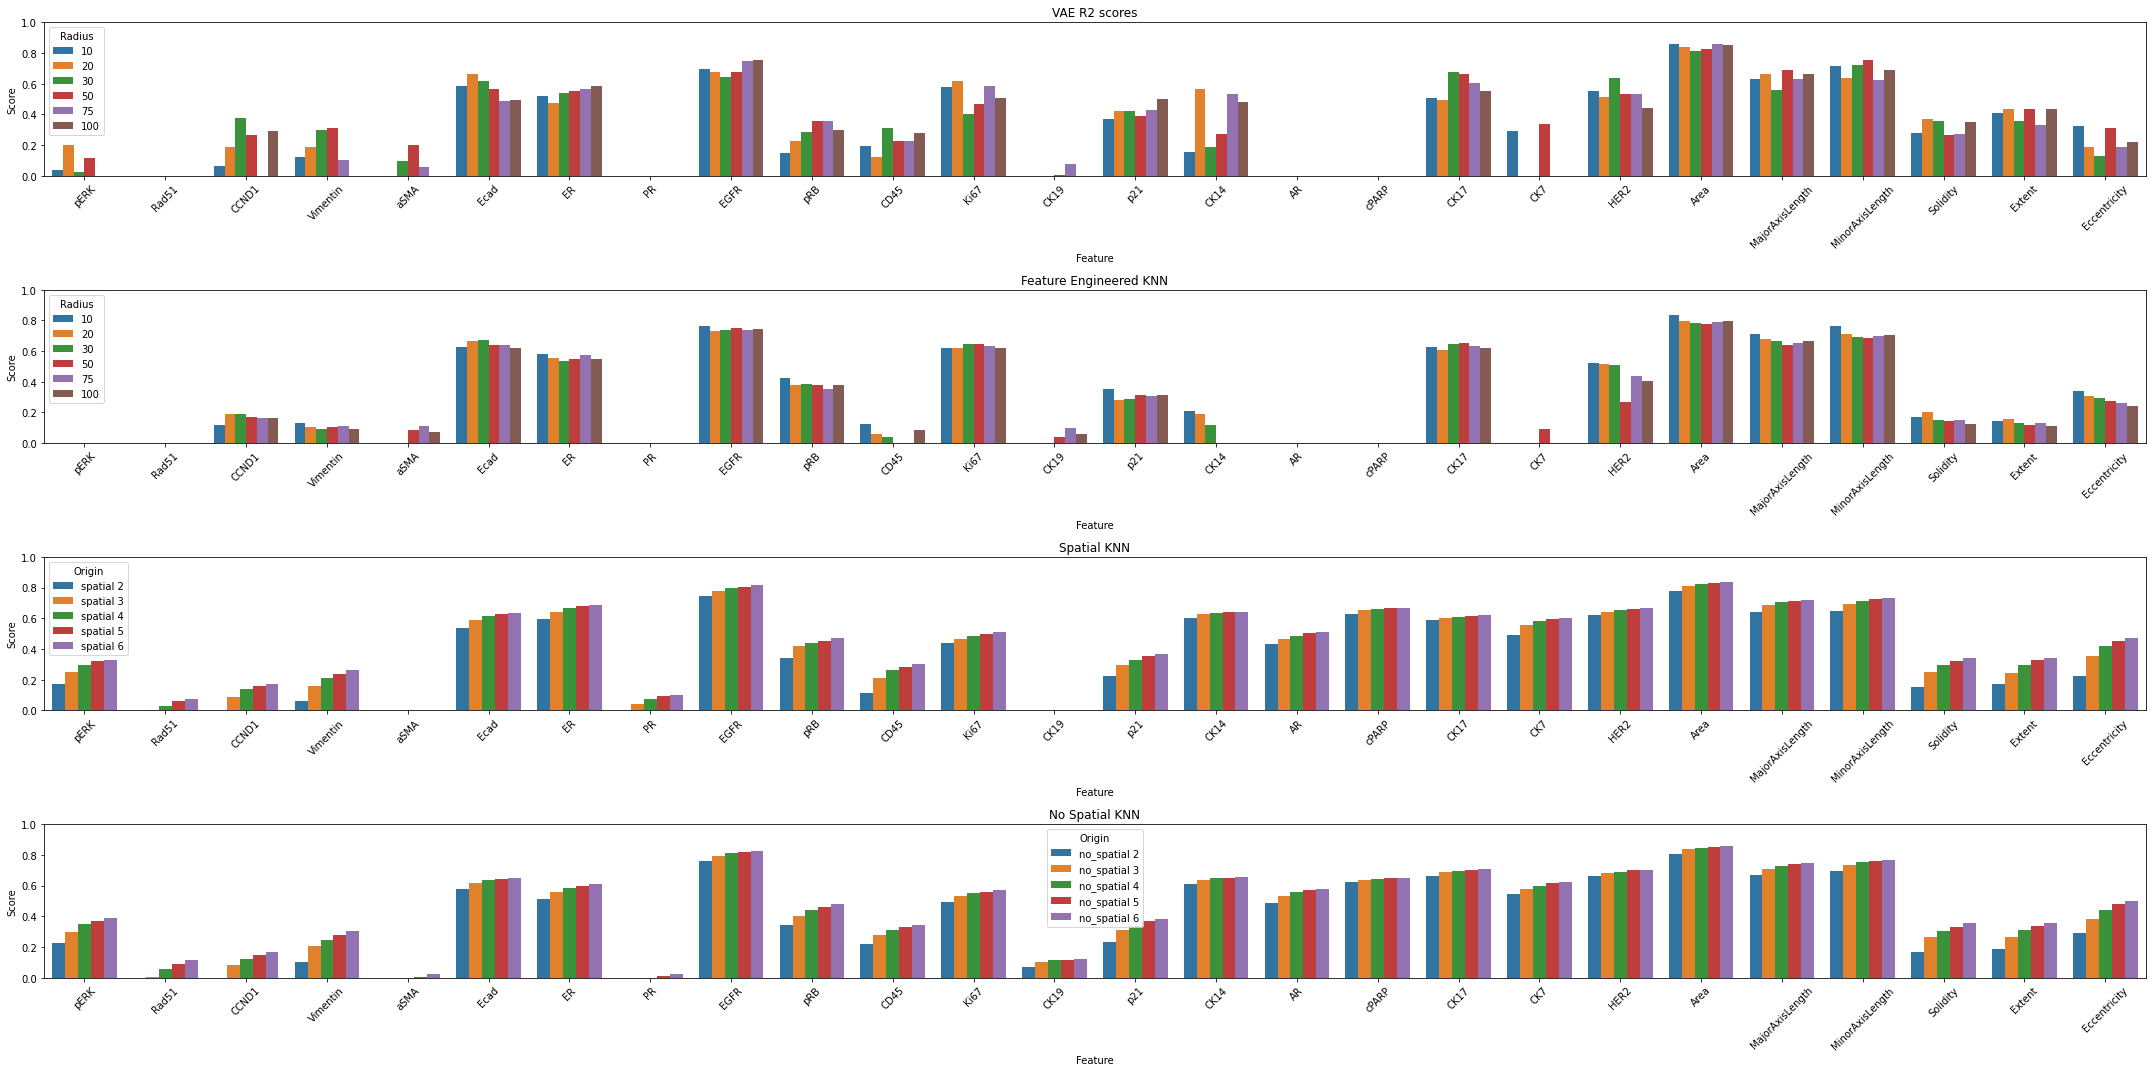

In [427]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)
fig.set_size_inches(30,15)

sns.barplot(x="Feature", y="Score",hue="Radius", data=vae_r2_scores, ax=ax1)
sns.barplot(x="Feature", y="Score",hue="Radius", data=distance_based_r2_scores, ax=ax2)
sns.barplot(x="Feature", y="Score",hue="Origin", data=spatial_neighboor_hood_scores, ax=ax3)
sns.barplot(x="Feature", y="Score",hue="Origin", data=no_spatial_neighboor_hood_scores, ax=ax4)

for ax in fig.axes:
    ax.set_ylim(0,1)

ax1.set_title("VAE R2 scores")
ax2.set_title("Feature Engineered KNN")
ax3.set_title("Spatial KNN")
ax4.set_title("No Spatial KNN")

ax3.set_ylim(0)

for ax in fig.axes:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
# set the spacing between subplots
fig.tight_layout()
plt.ylim(0)
plt.savefig(f"data/{case_to_evaluate}/vae_normal/knn_fe_knn_vae_score_overview.png",facecolor='w')

## Combine R2 scores

In [428]:
combined_r2_scores = pd.concat([distance_based_r2_scores,neighbor_based_r2_scores, vae_r2_scores])
combined_r2_scores

,Feature,Score,Radius,Origin
0,pERK,0.000000,10.0,Distance Based
1,Rad51,0.000000,10.0,Distance Based
2,CCND1,0.118162,10.0,Distance Based
3,Vimentin,0.130410,10.0,Distance Based
4,aSMA,0.000000,10.0,Distance Based
...,...,...,...,...
151,MajorAxisLength,0.665003,100.0,VAE
152,MinorAxisLength,0.687733,100.0,VAE
153,Solidity,0.352681,100.0,VAE
154,Extent,0.435679,100.0,VAE


## Find improved marker

Select features which performed better in different settings

In [429]:
def get_best_markers_for_neighbor_and_radius_based(radius_based_data: pd.DataFrame, neighbor_hood_based_data: pd.DataFrame, spatial: bool):
    features_of_interest = []
    
    origin = "no_spatial 6" if not spatial else "spatial 6"
    
    for feature in neighbor_hood_based_data["Feature"].unique():
        radius_based_score_data = radius_based_data.loc[radius_based_data["Feature"] == feature]
        neighbor_based_score_data = neighbor_hood_based_data.loc[neighbor_hood_based_data["Feature"] == feature]
        
        for radius in radius_based_data["Radius"].unique():
            compare_score_for_radius  = radius_based_score_data[radius_based_score_data["Radius"] == radius]
            neighbor_based_score_for_max_neighbor = neighbor_based_score_data[neighbor_based_score_data["Origin"] == origin]
            
            if compare_score_for_radius["Score"].values[0] > neighbor_based_score_for_max_neighbor["Score"].values[0]:
                features_of_interest.append({"Feature": compare_score_for_radius["Feature"].values[0], "Score": compare_score_for_radius["Score"].values[0], "Origin": compare_score_for_radius["Origin"].values[0], "Radius": compare_score_for_radius["Radius"].values[0]})
        
        
        
    return pd.DataFrame().from_records(features_of_interest)
    
    
    

In [430]:
def get_radius_based_best_markers(base_origin: str, compare_origin:str, data:pd.DataFrame):
    features_of_interest = []

    for feature in data["Feature"].unique():
        # data_to_focus = data.loc[(data["Origin"] == base_origin) | (data["Origin"] == compare_origin)]
        base_score_data = data.loc[(data["Origin"] == base_origin) & (data["Feature"] == feature)]
        compare_score_data = data.loc[(data["Origin"] == compare_origin) & (data["Feature"] == feature)]
     
        for radius in base_score_data["Radius"].unique():
            compare_score_for_radius  = compare_score_data[compare_score_data["Radius"] == radius]
            base_score_for_radius = base_score_data[base_score_data["Radius"] == radius]
            
            #print(compare_score)
            #print(base_score)
            
            if compare_score_for_radius["Score"].values[0] > base_score_for_radius["Score"].values[0]:
                features_of_interest.append({"Feature": compare_score_for_radius["Feature"].values[0], "Score": compare_score_for_radius["Score"].values[0], "Origin": compare_score_for_radius["Origin"].values[0], "Radius": compare_score_for_radius["Radius"].values[0]})
        
        
        
    return pd.DataFrame().from_records(features_of_interest)
    
    

## Calculate performance improvements for VAE vs FE KNN

In [431]:
vae_vs_fe_knn_improved_markers = get_radius_based_best_markers("Distance Based", "VAE", combined_r2_scores)
vae_vs_fe_knn_improved_markers

,Feature,Score,Origin,Radius
0,pERK,0.040020,VAE,10.0
1,pERK,0.198505,VAE,20.0
2,pERK,0.024371,VAE,30.0
3,pERK,0.119366,VAE,50.0
4,CCND1,0.190821,VAE,20.0
...,...,...,...,...
61,Extent,0.356940,VAE,30.0
62,Extent,0.437593,VAE,50.0
63,Extent,0.334220,VAE,75.0
64,Extent,0.435679,VAE,100.0


In [432]:
vae_vs_fe_knn_improved_markers.to_csv(f"data/{case_to_evaluate}/vae_vs_fe_knn_improved_features.csv", index=False)

In [433]:
for radius in vae_improved_markers["Radius"].unique():
    vae_marker_impro_count = len(vae_improved_markers[vae_improved_markers["Radius"] == radius])
    
    print(f"{vae_marker_impro_count / len(features_to_impute) * 100 } % of the available features improved by using a radius of {radius} and a VAE based imputation")

50.0 % of the available features improved by using a radius of 10.0 and a VAE based imputation
42.30769230769231 % of the available features improved by using a radius of 30.0 and a VAE based imputation
65.38461538461539 % of the available features improved by using a radius of 50.0 and a VAE based imputation
73.07692307692307 % of the available features improved by using a radius of 75.0 and a VAE based imputation
76.92307692307693 % of the available features improved by using a radius of 100.0 and a VAE based imputation
46.15384615384615 % of the available features improved by using a radius of 20.0 and a VAE based imputation


## Calculate performance improvements for FE KNN vs Spatial Neighborhood

In [434]:
fe_knn_improved_markers_vs_spatial = get_best_markers_for_neighbor_and_radius_based(distance_based_r2_scores, spatial_neighboor_hood_scores, True)

In [435]:


for radius in fe_knn_improved_markers_vs_spatial["Radius"].unique():
    fe_knn_marker_impro_count = len(fe_knn_improved_markers_vs_spatial[fe_knn_improved_markers_vs_spatial["Radius"] == radius])
    
    print(f"{fe_knn_marker_impro_count / len(features_to_impute) * 100 } % of the available features improved by using a radius of {radius} and a FE KNN based imputation")

19.230769230769234 % of the available features improved by using a radius of 20 and a FE KNN based imputation
23.076923076923077 % of the available features improved by using a radius of 30 and a FE KNN based imputation
19.230769230769234 % of the available features improved by using a radius of 10 and a FE KNN based imputation
19.230769230769234 % of the available features improved by using a radius of 50 and a FE KNN based imputation
19.230769230769234 % of the available features improved by using a radius of 75 and a FE KNN based imputation
15.384615384615385 % of the available features improved by using a radius of 100 and a FE KNN based imputation


In [436]:
fe_knn_improved_markers_vs_spatial.to_csv(f"data/{case_to_evaluate}/fe_knn_vs_spatial_neighborhood.csv", index=False)

## Calculate performance improvements for FE KNN vs Spatial Neighborhood

In [437]:
fe_knn_improved_markers_vs_non_spatial = get_best_markers_for_neighbor_and_radius_based(distance_based_r2_scores, no_spatial_neighboor_hood_scores, False)

In [438]:
fe_knn_improved_markers_vs_non_spatial.to_csv(f"data/{case_to_evaluate}/fe_knn_vs_no_spatial_neighborhood.csv", index=False)

In [439]:
for radius in fe_knn_improved_markers_vs_non_spatial["Radius"].unique():
    fe_knn_marker_impro_count = len(fe_knn_improved_markers_vs_non_spatial[fe_knn_improved_markers_vs_non_spatial["Radius"] == radius])
    
    print(f"{fe_knn_marker_impro_count / len(features_to_impute) * 100 } % of the available features improved by using a radius of {radius} and a FE KNN based imputation")

11.538461538461538 % of the available features improved by using a radius of 20 and a FE KNN based imputation
11.538461538461538 % of the available features improved by using a radius of 30 and a FE KNN based imputation
11.538461538461538 % of the available features improved by using a radius of 50 and a FE KNN based imputation
11.538461538461538 % of the available features improved by using a radius of 75 and a FE KNN based imputation
11.538461538461538 % of the available features improved by using a radius of 100 and a FE KNN based imputation
3.8461538461538463 % of the available features improved by using a radius of 10 and a FE KNN based imputation


In [440]:
#best_performing_features =best_r2_scores[pd.DataFrame(best_r2_scores["Feature"].tolist()).isin(features_of_interest["Feature"].tolist()).any(1).values]

In [441]:
#best_performing_features.to_csv(f"data/{case_to_evaluate}/distance_based/fe_best_performing_r2_scores.csv", index=False)

fig = plt.figure()
sns.barplot(x="Feature", y="Score",hue="Origin", data=best_performing_features)
for ax in fig.axes:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
fig.set_size_inches(15,7)
plt.ylim(0)
plt.show()

### Combine vae with fe knn scores

In [442]:

vae_r2_scores["Method"] = "VAE"
distance_based_r2_scores["Method"] = "FE KNN"
spatial_neighboor_hood_scores["Method"] = "Spatial NB KNN"
no_spatial_neighboor_hood_scores["Method"] = "No Spatial NB KNN"

spatial_neighboor_hood_scores[spatial_neighboor_hood_scores["Origin"] == "spatial 6"] 

vae_x_fe_knn_scores= pd.concat([vae_r2_scores,distance_based_r2_scores])
vae_x_fe_knn_scores.reset_index(drop=True, inplace=True)
vae_x_fe_knn_scores

,Feature,Score,Radius,Origin,Method
0,pERK,0.040020,10,VAE,VAE
1,Rad51,0.000000,10,VAE,VAE
2,CCND1,0.067134,10,VAE,VAE
3,Vimentin,0.122321,10,VAE,VAE
4,aSMA,0.000000,10,VAE,VAE
...,...,...,...,...,...
307,MajorAxisLength,0.663187,100,Distance Based,FE KNN
308,MinorAxisLength,0.702906,100,Distance Based,FE KNN
309,Solidity,0.123418,100,Distance Based,FE KNN
310,Extent,0.112796,100,Distance Based,FE KNN


In [446]:
# Create mean scores across all markers
mean_scores_per_origin_data = []
for origin in vae_x_fe_knn_scores["Radius"].unique():
    data = vae_x_fe_knn_scores[vae_x_fe_knn_scores["Radius"] == origin]
    mean_scores_per_origin_data.append(
        {
            "Score": data[data["Method"] == "VAE"]["Score"].median(),
            "Method": "VAE",
            "Origin": origin
        }
    )
    
    mean_scores_per_origin_data.append(
        {
            "Score": data[data["Method"] == "FE KNN"]["Score"].median(),
            "Method": "FE KNN",
            "Origin": origin
        }
    )
    
mean_scores_per_origin = pd.DataFrame().from_records(mean_scores_per_origin_data)
mean_scores_per_origin

,Score,Method,Origin
0,0.285080,VAE,10
1,0.188703,FE KNN,10
2,0.300646,VAE,20
3,0.194575,FE KNN,20
4,0.335678,VAE,30
5,0.172373,FE KNN,30
6,0.325054,VAE,50
7,0.156590,FE KNN,50
8,0.303325,VAE,75
9,0.159948,FE KNN,75


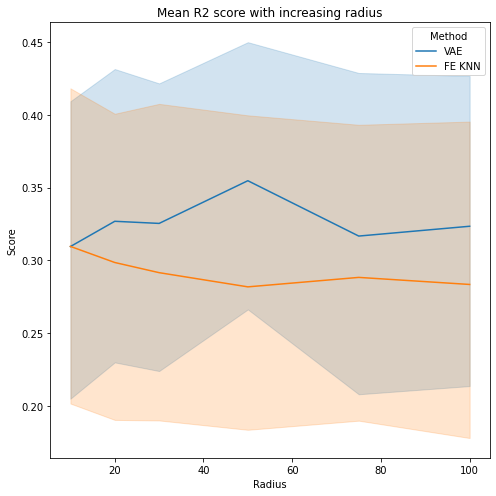

In [447]:
fig = plt.figure(figsize=(7, 7))
ax = sns.lineplot(data=vae_x_fe_knn_scores, x="Radius", y="Score", hue="Method")
#ax.fill_between(vae_x_fe_knn_scores.index, vae_x_fe_knn_scores.lower, vae_x_fe_knn_scores.upper, alpha=0.2)
plt.xlabel("Radius")

plt.title("Mean R2 score with increasing radius")
fig.tight_layout()
plt.savefig(f"data/{case_to_evaluate}/vae_vs_fe_knn_mean_performance_comparison.png",facecolor='w')

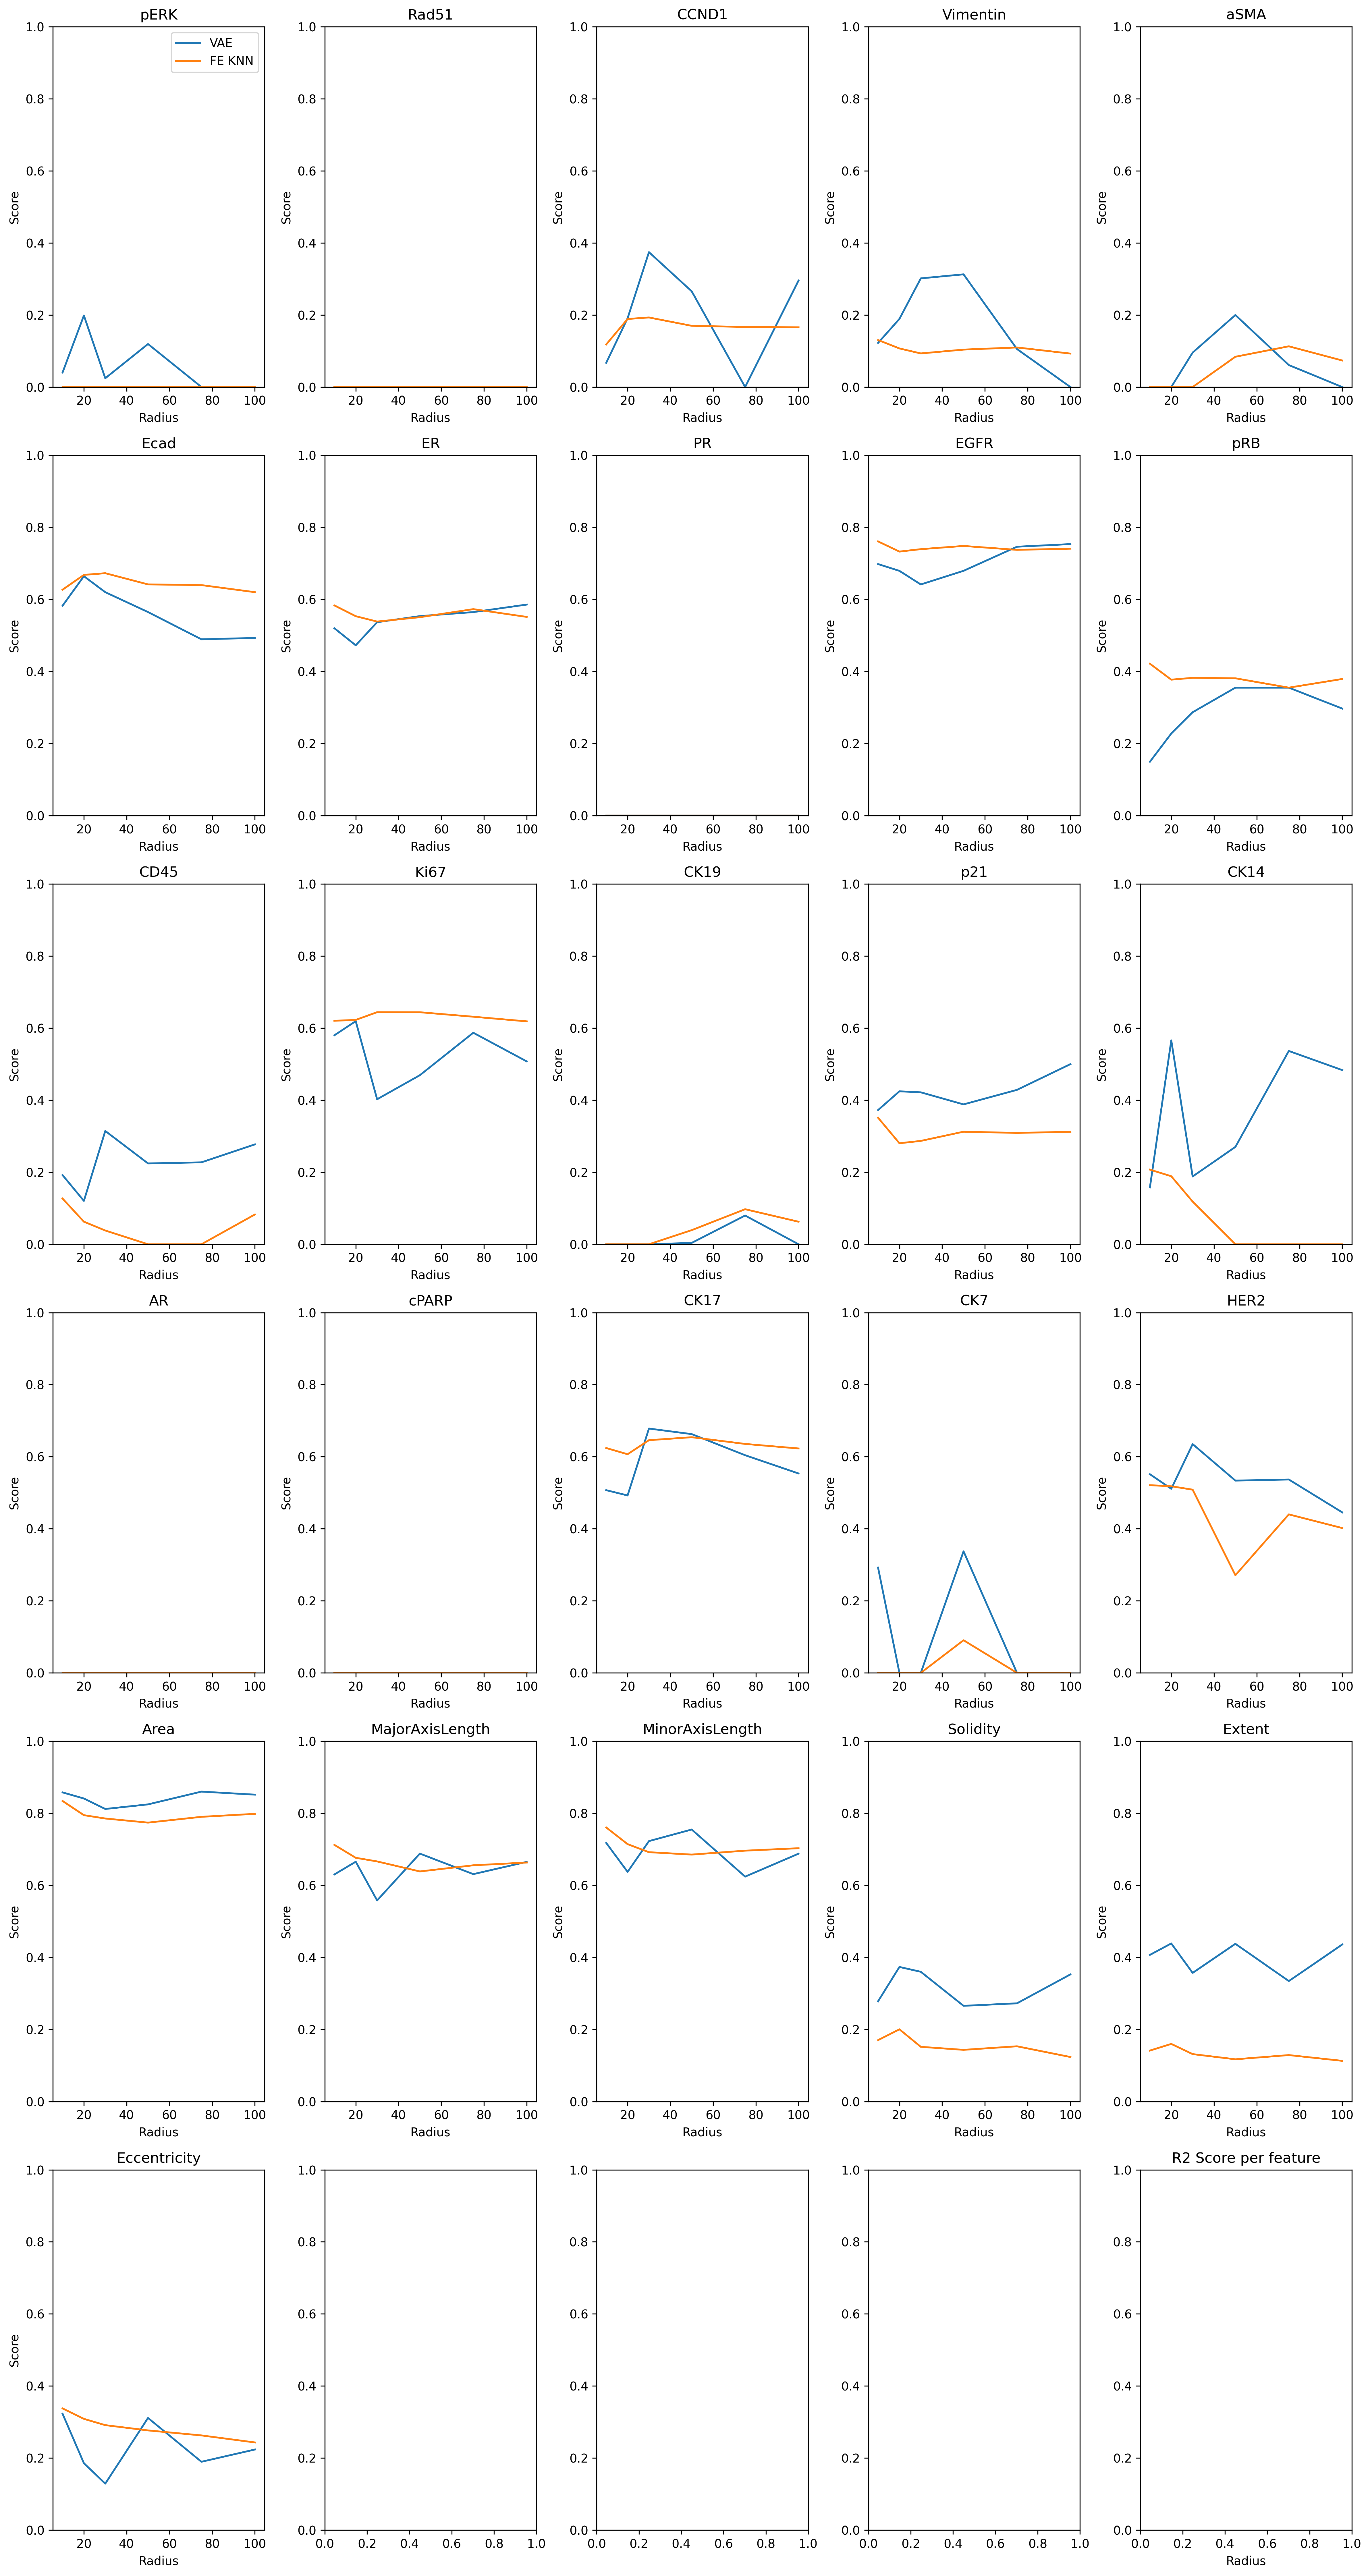

In [448]:
fig, axs = plt.subplots(6, 5, figsize=(16, 30), dpi=300)

row = 0
col = 0

for feature in vae_x_fe_knn_scores["Feature"].unique():
    sns.lineplot(data=vae_x_fe_knn_scores[vae_x_fe_knn_scores["Feature"] == feature], x="Radius", y="Score", hue="Method", ax=axs[col, row])
    axs[col, row].set_title(feature)
    axs[col, row].get_legend().remove()
    axs[col, row].set_ylim(0, 1)
    
    row +=1
    
    if row == 5:
        row = 0
        col += 1

        
axs[0][0].legend()

plt.xlabel("Radius")
plt.title("R2 Score per feature")
fig.tight_layout()
plt.savefig(f"data/{case_to_evaluate}/vae_fe_knn_feature_performance.png",facecolor='w')

